In [ ]:
import os
import json
import random
import numpy as np
import config
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction



config.training_label = "/kaggle/input/data-k"
config.max_length = 15
config.epochs = 50
config.batch_size = 64
config.num_decoder_tokens = 6000
# config.num_decoder_tokens = 1500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
class VideoDataset():
    def __init__(self):
        self.x_data = {}
        self.encoder = EncoderModel().to(device)  
        self.decoder = DecoderModel().to(device) 
        self.lr = config.learning_rate
        self.epochs = config.epochs
        self.save_model_path = config.save_model_path
        self.patience = 3  
        self.min_delta = 0.001
    def preprocessing(self):
   
        TRAIN_LABEL_PATH = os.path.join(config.training_label, '/kaggle/input/data-k/data (2).json')
        with open(TRAIN_LABEL_PATH) as data_file:
            y_data = json.load(data_file)
        
        train_list = []
        vocab_list = []

        # Prepare train_list and vocab_list
        for i,y in enumerate(y_data):
            for caption in y_data[f"{i}"]['caption']:
                caption = "<bos> " + caption + " <eos>"
                if len(caption.split()) <= 15:
                    train_list.append([caption, y_data[f"{i}"]['id']])

        # Shuffle and split data
        random.shuffle(train_list)
        training_list = train_list[int(len(train_list) * config.validation_split):]
        validation_list = train_list[:int(len(train_list) * config.validation_split)]

        # Build vocabulary
        for train in training_list:
            vocab_list.append(train[0])
        self.tokenizer = Tokenizer(num_words=config.num_decoder_tokens)
        self.tokenizer.fit_on_texts(vocab_list)

        # Load video features
        TRAIN_FEATURE_DIR = os.path.join(config.train_feet, 'feat')
        for filename in os.listdir(TRAIN_FEATURE_DIR):
            f = np.load(os.path.join(TRAIN_FEATURE_DIR, filename), allow_pickle=True)
            self.x_data[filename[:-4]] = f

        return training_list,self.x_data,validation_list

    def load_dataset(self, training_list):
   
        encoder_input_data = []
        decoder_input_data = []
        decoder_target_data = []
        videoId = []
        videoSeq = []
        
        # Prepare caption sequences
        for idx, cap in enumerate(training_list): 
            caption = cap[0]
            videoId.append(cap[1])
            videoSeq.append(caption)
        
        train_sequences = self.tokenizer.texts_to_sequences(videoSeq)
        train_sequences = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=config.max_length)
        train_sequences = np.array(train_sequences)

        file_size = len(train_sequences)
        n = 0
    
        for idx in range(0, file_size):
            n += 1
            
            encoder_input_data.append(self.x_data[videoId[idx]])
            y = to_categorical(train_sequences[idx], config.num_decoder_tokens)
            decoder_input_data.append(y[:-1])
            decoder_target_data.append(y[1:])

            if n == config.batch_size:
                encoder_input_n = np.array(encoder_input_data)
                decoder_input_n = np.array(decoder_input_data)
                decoder_target_n = np.array(decoder_target_data)

                encoder_input = torch.tensor(encoder_input_n, dtype=torch.float32).to(device)
                decoder_input = torch.tensor(decoder_input_n, dtype=torch.float32).to(device)
                decoder_target = torch.tensor(decoder_target_n, dtype=torch.float32).to(device)

                encoder_input_data = []
                decoder_input_data = []
                decoder_target_data = []
                n = 0

                yield ([encoder_input, decoder_input], decoder_target)


    def train(self):

        training_list, x_data,validation_list = self.preprocessing()

        optimizer = optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        training_losses = []
        validation_losses = []
        bleu_scores = []
        best_val_loss = float('inf')
        patience_counter = 0
        run_epoch=0

        for epoch in range(self.epochs):
            # Training loop
            self.encoder.train()
            self.decoder.train()
            train_loader = self.load_dataset(training_list)
            total_train_loss = 0
            train_steps = 0
            run_epoch = run_epoch+1

            for [encoder_input, decoder_input], decoder_target in train_loader:

                decoder_target = torch.argmax(decoder_target, dim=-1)  # Convert to class indices

                encoder_state = self.encoder(encoder_input)
                decoder_output = self.decoder(decoder_input, encoder_state)

                loss = criterion(decoder_output.view(-1, config.num_decoder_tokens), decoder_target.view(-1))
                total_train_loss += loss.item()

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                train_steps += 1  
                if train_steps % 500 == 0:
                    print(f"Epoch {epoch + 1}, Step {train_steps}: Training Loss = {total_train_loss / train_steps}")

            average_train_loss = total_train_loss / train_steps 

            training_losses.append(average_train_loss)

            # Validation loop
            self.encoder.eval()
            self.decoder.eval()
            total_val_loss = 0
            val_steps = 0
            total_sequences = 0
            total_bleu = 0 
            with torch.no_grad():  
                valid_loader = self.load_dataset(validation_list)
                for [encoder_input, decoder_input], decoder_target in valid_loader:
   
                    decoder_target = torch.argmax(decoder_target, dim=-1)
        
                    encoder_state = self.encoder(encoder_input)
                    decoder_output = self.decoder(decoder_input, encoder_state)

                    val_loss = criterion(decoder_output.view(-1, config.num_decoder_tokens), decoder_target.view(-1))
                    total_val_loss += val_loss.item()
                    predicted_sequences = torch.argmax(decoder_output, dim=-1)
                    reference_sequences = decoder_target
                    for i in range(len(predicted_sequences)):
                        total_sequences += 1
                        predicted_caption = [self.tokenizer.index_word.get(idx.item(), '<unk>') for idx in predicted_sequences[i] if idx > 2]
                        reference_caption = [[self.tokenizer.index_word.get(idx.item(), '<unk>') for idx in reference_sequences[i] if idx > 2]]

                        smooth_fn = SmoothingFunction().method1
                        bleu_score = sentence_bleu(reference_caption, predicted_caption)
                        total_bleu += bleu_score

                    val_steps += 1  

                average_bleu = total_bleu / total_sequences
                bleu_scores.append(average_bleu)
                average_val_loss = total_val_loss / val_steps 
                validation_losses.append(average_val_loss)
                print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}, BLEU Score: {average_bleu}')
                if average_val_loss < best_val_loss - self.min_delta:
                    best_val_loss = average_val_loss
                    patience_counter = 0 
                    print(f"Validation loss improved to {best_val_loss}. Saving model.")
                    torch.save(self.encoder.state_dict(), os.path.join(self.save_model_path, 'encoder_model_lstm.pth'))
                    torch.save(self.decoder.state_dict(), os.path.join(self.save_model_path, 'decoder_model_lstm.pth'))
                    with open(os.path.join(self.save_model_path, 'tokenizer_lstm_' + str(config.num_decoder_tokens)), 'wb') as file:
                        joblib.dump(self.tokenizer, file)
                else:
                    patience_counter += 1
                    print(f"No improvement for {patience_counter} epochs.")
                    if patience_counter >= self.patience:
                        print(f"Early stopping triggered after {epoch + 1} epochs.")
                        break

        # Plot the training and validation loss and bleu score 
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, run_epoch+1), training_losses, label='Training Loss')
        plt.plot(range(1, run_epoch+1), validation_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss per Epoch')
        plt.legend()
        plt.show()
        plt.plot(range(1, run_epoch+1), bleu_scores, label='bleu_scores')
        plt.show()    



class EncoderModel(nn.Module):
    def __init__(self):
        super(EncoderModel, self).__init__()
        self.encoder = nn.LSTM(input_size=config.num_encoder_tokens, hidden_size=config.latent_dim, batch_first=True)
        
    def forward(self, encoder_inputs):
        encoder_outputs, (state_h, state_c) = self.encoder(encoder_inputs)
        return (state_h, state_c)


class DecoderModel(nn.Module):
    def __init__(self):
        super(DecoderModel, self).__init__()
        self.decoder = nn.LSTM(input_size=config.num_decoder_tokens, hidden_size=config.latent_dim, batch_first=True)
        self.decoder_dense = nn.Linear(config.latent_dim, config.num_decoder_tokens)
        
    def forward(self, decoder_inputs, encoder_states):
        decoder_outputs, _ = self.decoder(decoder_inputs, encoder_states)
        final_outputs = self.decoder_dense(decoder_outputs)
        return final_outputs



cuda


Epoch 1, Step 500: Training Loss = 3.389263093471527
Epoch 1, Step 1000: Training Loss = 3.071021417379379


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Epoch 1/50, Training Loss: 2.8871977963125857, Validation Loss: 2.4194721335714515, BLEU Score: 0.5198927490872315
Validation loss improved to 2.4194721335714515. Saving model.
Epoch 2, Step 500: Training Loss = 2.3752271809577943
Epoch 2, Step 1000: Training Loss = 2.318087190747261
Epoch 2/50, Training Loss: 2.2719606058392112, Validation Loss: 2.168682570258776, BLEU Score: 0.5293635227433711
Validation loss improved to 2.168682570258776. Saving model.
Epoch 3, Step 500: Training Loss = 2.122441678762436
Epoch 3, Step 1000: Training Loss = 2.0910165469646453
Epoch 3/50, Training Loss: 2.064817991110191, Validation Loss: 2.0549439417593405, BLEU Score: 0.5265922311281298
Validation loss improved to 2.0549439417593405. Saving model.
Epoch 4, Step 500: Training Loss = 1.9778856031894685
Epoch 4, Step 1000: Training Loss = 1.9541797337532043
Epoch 4/50, Training Loss: 1.9345895684235241, Validation Loss: 1.9917128040935055, BLEU Score: 0.5270273409636721
Validation loss improved to 1.99

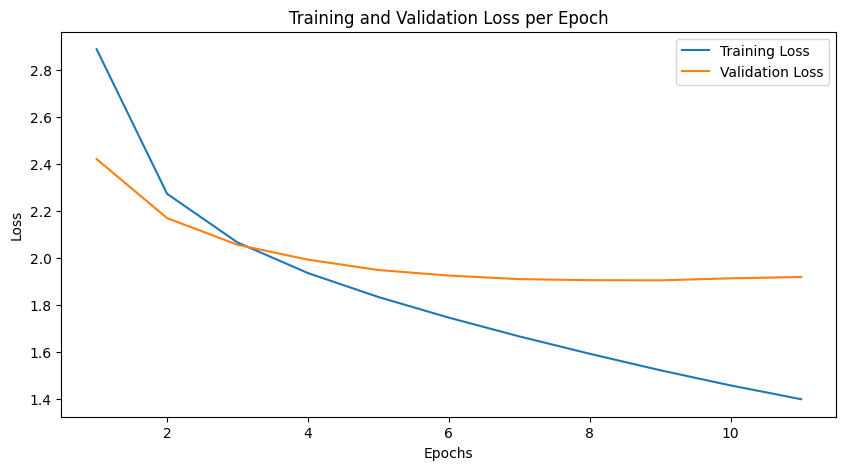

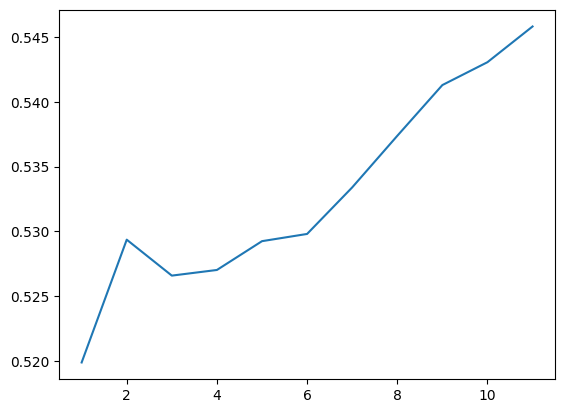

In [2]:
dataset = VideoDataset()
dataset.train()

In [ ]:
import os
import json
import random
import numpy as np
import config
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction



config.training_label = "/kaggle/input/data-k"
config.max_length = 15
config.epochs = 50
config.batch_size = 64
config.num_decoder_tokens = 6000
# config.num_decoder_tokens = 1500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
class VideoDataset():
    def __init__(self):
        self.x_data = {}
        self.encoder = EncoderModel().to(device) 
        self.decoder = DecoderModel().to(device)  
        self.lr = config.learning_rate
        self.epochs = config.epochs
        self.save_model_path = config.save_model_path
        self.patience = 3  
        self.min_delta = 0.001
    def preprocessing(self):

        TRAIN_LABEL_PATH = os.path.join(config.training_label, '/kaggle/input/data-k/data (2).json')
        with open(TRAIN_LABEL_PATH) as data_file:
            y_data = json.load(data_file)
        
        train_list = []
        vocab_list = []

        # Prepare train_list and vocab_list
        for i,y in enumerate(y_data):
            for caption in y_data[f"{i}"]['caption']:
                caption = "<bos> " + caption + " <eos>"
                if len(caption.split()) <= 15:
                    train_list.append([caption, y_data[f"{i}"]['id']])

        # Shuffle and split data
        random.shuffle(train_list)
        training_list = train_list[int(len(train_list) * config.validation_split):]
        validation_list = train_list[:int(len(train_list) * config.validation_split)]

        # Build vocabulary
        for train in training_list:
            vocab_list.append(train[0])
        self.tokenizer = Tokenizer(num_words=config.num_decoder_tokens)
        self.tokenizer.fit_on_texts(vocab_list)

        # Load video features
        TRAIN_FEATURE_DIR = os.path.join(config.train_feet, 'feat')
        for filename in os.listdir(TRAIN_FEATURE_DIR):
            f = np.load(os.path.join(TRAIN_FEATURE_DIR, filename), allow_pickle=True)
            self.x_data[filename[:-4]] = f

        return training_list,self.x_data,validation_list

    def load_dataset(self, training_list):
  
        encoder_input_data = []
        decoder_input_data = []
        decoder_target_data = []
        videoId = []
        videoSeq = []
        
        # Prepare caption sequences
        for idx, cap in enumerate(training_list): 
            caption = cap[0]
            videoId.append(cap[1])
            videoSeq.append(caption)
        
        train_sequences = self.tokenizer.texts_to_sequences(videoSeq)
        train_sequences = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=config.max_length)
        train_sequences = np.array(train_sequences)

        file_size = len(train_sequences)
        n = 0
    
        for idx in range(0, file_size):
            n += 1
            
            encoder_input_data.append(self.x_data[videoId[idx]])
            y = to_categorical(train_sequences[idx], config.num_decoder_tokens)
            decoder_input_data.append(y[:-1])
            decoder_target_data.append(y[1:])

            if n == config.batch_size:
                encoder_input_n = np.array(encoder_input_data)
                decoder_input_n = np.array(decoder_input_data)
                decoder_target_n = np.array(decoder_target_data)

             
                encoder_input = torch.tensor(encoder_input_n, dtype=torch.float32).to(device)
                decoder_input = torch.tensor(decoder_input_n, dtype=torch.float32).to(device)
                decoder_target = torch.tensor(decoder_target_n, dtype=torch.float32).to(device)

                encoder_input_data = []
                decoder_input_data = []
                decoder_target_data = []
                n = 0

                yield ([encoder_input, decoder_input], decoder_target)


    def train(self):
  
        training_list, x_data,validation_list = self.preprocessing()


        optimizer = optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

    
        training_losses = []
        validation_losses = []
        bleu_scores = []
        best_val_loss = float('inf')
        patience_counter = 0
        run_epoch=0

        for epoch in range(self.epochs):
            # Training loop
            self.encoder.train()
            self.decoder.train()
            train_loader = self.load_dataset(training_list)
            total_train_loss = 0
            train_steps = 0
            run_epoch = run_epoch+1

            for [encoder_input, decoder_input], decoder_target in train_loader:
        
                decoder_target = torch.argmax(decoder_target, dim=-1) 

                # Forward pass
                encoder_state = self.encoder(encoder_input)
                decoder_output = self.decoder(decoder_input, encoder_state)

                # Compute loss
                loss = criterion(decoder_output.view(-1, config.num_decoder_tokens), decoder_target.view(-1))
                total_train_loss += loss.item()

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                train_steps += 1  
                if train_steps % 500 == 0:
                    print(f"Epoch {epoch + 1}, Step {train_steps}: Training Loss = {total_train_loss / train_steps}")

            average_train_loss = total_train_loss / train_steps 

            training_losses.append(average_train_loss)

            self.encoder.eval()
            self.decoder.eval()
            total_val_loss = 0
            val_steps = 0
            total_sequences = 0
            total_bleu = 0 
            with torch.no_grad(): 
                valid_loader = self.load_dataset(validation_list)
                for [encoder_input, decoder_input], decoder_target in valid_loader:

                    decoder_target = torch.argmax(decoder_target, dim=-1)
            
                    encoder_state = self.encoder(encoder_input)
                    decoder_output = self.decoder(decoder_input, encoder_state)

                    val_loss = criterion(decoder_output.view(-1, config.num_decoder_tokens), decoder_target.view(-1))
                    total_val_loss += val_loss.item()
                    predicted_sequences = torch.argmax(decoder_output, dim=-1)
                    reference_sequences = decoder_target
                    for i in range(len(predicted_sequences)):
                        total_sequences += 1
                        predicted_caption = [self.tokenizer.index_word.get(idx.item(), '<unk>') for idx in predicted_sequences[i] if idx > 2]
                        reference_caption = [[self.tokenizer.index_word.get(idx.item(), '<unk>') for idx in reference_sequences[i] if idx > 2]]

                        smooth_fn = SmoothingFunction().method1
                        bleu_score = sentence_bleu(reference_caption, predicted_caption)
                        total_bleu += bleu_score

                    val_steps += 1  

                average_bleu = total_bleu / total_sequences
                bleu_scores.append(average_bleu)
                average_val_loss = total_val_loss / val_steps 
                validation_losses.append(average_val_loss)
                print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}, BLEU Score: {average_bleu}')
                if average_val_loss < best_val_loss - self.min_delta:
                    best_val_loss = average_val_loss
                    patience_counter = 0  
                    print(f"Validation loss improved to {best_val_loss}. Saving model.")
                    torch.save(self.encoder.state_dict(), os.path.join(self.save_model_path, 'encoder_model_gru.pth'))
                    torch.save(self.decoder.state_dict(), os.path.join(self.save_model_path, 'decoder_model_gru.pth'))
                    with open(os.path.join(self.save_model_path, 'tokenizer_gru_' + str(config.num_decoder_tokens)), 'wb') as file:
                        joblib.dump(self.tokenizer, file)
                else:
                    patience_counter += 1
                    print(f"No improvement for {patience_counter} epochs.")
                    if patience_counter >= self.patience:
                        print(f"Early stopping triggered after {epoch + 1} epochs.")
                        break

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, run_epoch+1), training_losses, label='Training Loss')
        plt.plot(range(1, run_epoch+1), validation_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss per Epoch')
        plt.legend()
        plt.show()
        plt.plot(range(1, run_epoch+1), bleu_scores, label='bleu_scores')
        plt.show()    



class EncoderModel(nn.Module):
    def __init__(self):
        super(EncoderModel, self).__init__()
        self.encoder = nn.GRU(input_size=config.num_encoder_tokens, hidden_size=config.latent_dim, batch_first=True)
        
    def forward(self, encoder_inputs):

        encoder_outputs, state_h = self.encoder(encoder_inputs)
        return state_h  


class DecoderModel(nn.Module):
    def __init__(self):
        super(DecoderModel, self).__init__()

        self.decoder = nn.GRU(input_size=config.num_decoder_tokens, hidden_size=config.latent_dim, batch_first=True)
        self.decoder_dense = nn.Linear(config.latent_dim, config.num_decoder_tokens)
        
    def forward(self, decoder_inputs, encoder_states):
        decoder_outputs, _ = self.decoder(decoder_inputs, encoder_states)
        final_outputs = self.decoder_dense(decoder_outputs)
        return final_outputs




cuda


Epoch 1, Step 500: Training Loss = 3.3436099767684935
Epoch 1, Step 1000: Training Loss = 2.975023545026779
Epoch 1/50, Training Loss: 2.775398626117286, Validation Loss: 2.2788941634423807, BLEU Score: 0.5464132758324782
Validation loss improved to 2.2788941634423807. Saving model.
Epoch 2, Step 500: Training Loss = 2.2489493086338044
Epoch 2, Step 1000: Training Loss = 2.192654838681221
Epoch 2/50, Training Loss: 2.151874174654444, Validation Loss: 2.0679999454454943, BLEU Score: 0.5416189893995015
Validation loss improved to 2.0679999454454943. Saving model.
Epoch 3, Step 500: Training Loss = 2.016380287647247
Epoch 3, Step 1000: Training Loss = 1.9815849397182466
Epoch 3/50, Training Loss: 1.9567574107336376, Validation Loss: 1.971583379940553, BLEU Score: 0.5441212419963106
Validation loss improved to 1.971583379940553. Saving model.
Epoch 4, Step 500: Training Loss = 1.869433049440384
Epoch 4, Step 1000: Training Loss = 1.8420716512203217
Epoch 4/50, Training Loss: 1.823047520322

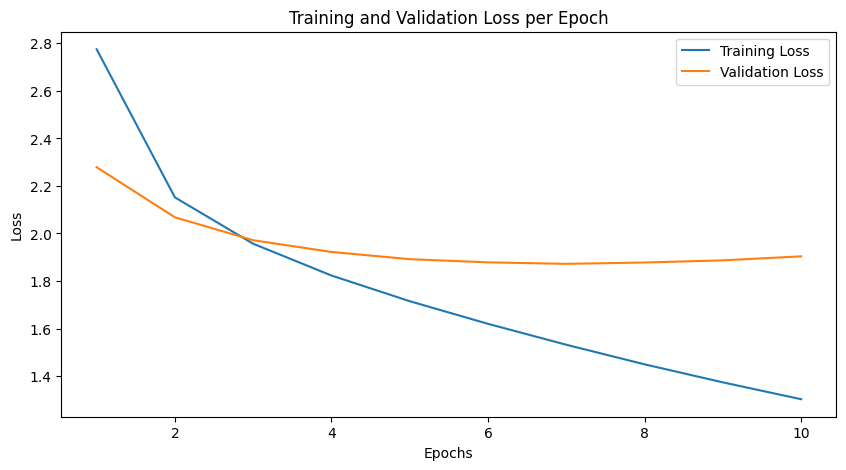

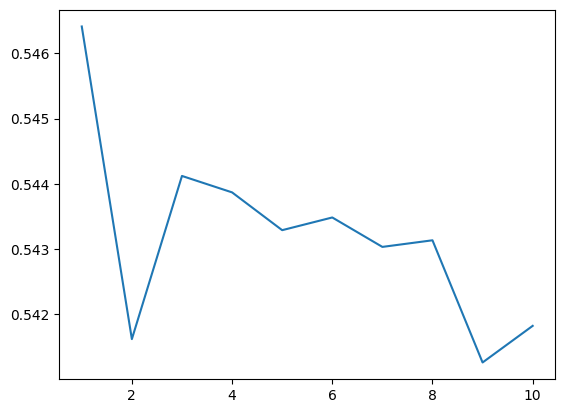

In [4]:
dataset = VideoDataset()
dataset.train()

10 10 9

In [5]:
# import os
# import json
# import random
# import numpy as np
# import config
# from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import joblib
# import matplotlib.pyplot as plt
# import nltk
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction



# config.training_label = "/kaggle/input/data-k"
# config.max_length = 15
# config.epochs = 50
# config.batch_size = 64
# confignum_decoder_tokens = 6000
# # config.num_decoder_tokens = 1500
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# class VideoDataset():
#     def __init__(self):
#         self.x_data = {}
#         self.encoder = EncoderModel().to(device)  # Move encoder to GPU
#         self.decoder = DecoderModel().to(device)  # Move decoder to GPU
#         self.lr = config.learning_rate
#         self.epochs = config.epochs
#         self.save_model_path = config.save_model_path
#         self.patience = 3  # Number of epochs to wait before stopping if no improvement
#         self.min_delta = 0.001
#     def preprocessing(self):
#         """
#         Preprocesses the dataset, loads training data, and creates vocabulary.
#         :return: training_list, validation_list, and video feature data.
#         """
#         TRAIN_LABEL_PATH = os.path.join(config.training_label, '/kaggle/input/data-k/data (2).json')
#         with open(TRAIN_LABEL_PATH) as data_file:
#             y_data = json.load(data_file)
        
#         train_list = []
#         vocab_list = []

#         # Prepare train_list and vocab_list
#         for i,y in enumerate(y_data):
#             for caption in y_data[f"{i}"]['caption']:
#                 caption = "<bos> " + caption + " <eos>"
#                 if len(caption.split()) <= 15:
#                     train_list.append([caption, y_data[f"{i}"]['id']])

#         # Shuffle and split data
#         random.shuffle(train_list)
#         training_list = train_list[int(len(train_list) * config.validation_split):]
#         validation_list = train_list[:int(len(train_list) * config.validation_split)]

#         # Build vocabulary
#         for train in training_list:
#             vocab_list.append(train[0])
#         self.tokenizer = Tokenizer(num_words=config.num_decoder_tokens)
#         self.tokenizer.fit_on_texts(vocab_list)

#         # Load video features
#         TRAIN_FEATURE_DIR = os.path.join(config.train_feet, 'feat')
#         for filename in os.listdir(TRAIN_FEATURE_DIR):
#             f = np.load(os.path.join(TRAIN_FEATURE_DIR, filename), allow_pickle=True)
#             self.x_data[filename[:-4]] = f

#         return training_list,self.x_data,validation_list

#     def load_dataset(self, training_list):
#         """
#         Loads the dataset in batches for training.
#         :param training_list: List of video caption pairs for training.
#         :return: Generator yielding batches of data.
#         """
#         encoder_input_data = []
#         decoder_input_data = []
#         decoder_target_data = []
#         videoId = []
#         videoSeq = []
        
#         # Prepare caption sequences
#         for idx, cap in enumerate(training_list): 
#             caption = cap[0]
#             videoId.append(cap[1])
#             videoSeq.append(caption)
        
#         train_sequences = self.tokenizer.texts_to_sequences(videoSeq)
#         train_sequences = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=config.max_length)
#         train_sequences = np.array(train_sequences)
# #         print(train_sequences)
#         file_size = len(train_sequences)
#         n = 0
    
#         for idx in range(0, file_size):
#             n += 1
            
#             encoder_input_data.append(self.x_data[videoId[idx]])
#             y = to_categorical(train_sequences[idx], config.num_decoder_tokens)
#             decoder_input_data.append(y[:-1])
#             decoder_target_data.append(y[1:])

#             if n == config.batch_size:
#                 encoder_input_n = np.array(encoder_input_data)
#                 decoder_input_n = np.array(decoder_input_data)
#                 decoder_target_n = np.array(decoder_target_data)

#                 # Convert data to PyTorch tensors
#                 encoder_input = torch.tensor(encoder_input_n, dtype=torch.float32).to(device)
#                 decoder_input = torch.tensor(decoder_input_n, dtype=torch.float32).to(device)
#                 decoder_target = torch.tensor(decoder_target_n, dtype=torch.float32).to(device)

#                 encoder_input_data = []
#                 decoder_input_data = []
#                 decoder_target_data = []
#                 n = 0

#                 yield ([encoder_input, decoder_input], decoder_target)


#     def train(self):
#         """
#         Trains the encoder-decoder model using the video dataset and calculates validation loss.
#         Also plots the training and validation loss graph.
#         """
#         training_list, x_data,validation_list = self.preprocessing()
# #         validation_list, _ = self.preprocessing(validation=True)  # Assuming a separate preprocessing for validation

#         optimizer = optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
#         criterion = nn.CrossEntropyLoss()

#         # Lists to store average training and validation loss per epoch
#         training_losses = []
#         validation_losses = []
#         bleu_scores = []
#         best_val_loss = float('inf')
#         patience_counter = 0
#         run_epoch=0

#         for epoch in range(self.epochs):
#             # Training loop
#             self.encoder.train()
#             self.decoder.train()
#             train_loader = self.load_dataset(training_list)
#             total_train_loss = 0
#             train_steps = 0
#             run_epoch = run_epoch+1

#             for [encoder_input, decoder_input], decoder_target in train_loader:
#                 # Decoder targets should be token indices, not one-hot encoded
#                 decoder_target = torch.argmax(decoder_target, dim=-1)  # Convert to class indices

#                 # Forward pass
#                 encoder_outputs, encoder_state = self.encoder(encoder_input)
#                 decoder_output = self.decoder(decoder_input, encoder_state,encoder_outputs)

#                 # Compute loss
#                 loss = criterion(decoder_output.view(-1, config.num_decoder_tokens), decoder_target.view(-1))
#                 total_train_loss += loss.item()

#                 # Backward pass and optimize
#                 loss.backward()
#                 optimizer.step()
#                 optimizer.zero_grad()

#                 train_steps += 1  # Increment step counter
#                 if train_steps % 500 == 0:
#                     print(f"Epoch {epoch + 1}, Step {train_steps}: Training Loss = {total_train_loss / train_steps}")

#             average_train_loss = total_train_loss / train_steps 

#             # Calculate average training loss for the epoch
# #             average_train_loss = total_train_loss / len(train_loader[0])
#             training_losses.append(average_train_loss)

#             # Validation loop
#             self.encoder.eval()
#             self.decoder.eval()
#             total_val_loss = 0
#             val_steps = 0
#             total_sequences = 0
#             total_bleu = 0 
#             with torch.no_grad():  # Disable gradient computation
#                 valid_loader = self.load_dataset(validation_list)
#                 for [encoder_input, decoder_input], decoder_target in valid_loader:
#                     # Decoder targets should be token indices, not one-hot encoded
#                     decoder_target = torch.argmax(decoder_target, dim=-1)
#                     # Forward pass
#                     encoder_outputs,encoder_state = self.encoder(encoder_input)
#                     decoder_output = self.decoder(decoder_input, encoder_state,encoder_outputs)

#                     # Compute loss
#                     val_loss = criterion(decoder_output.view(-1, config.num_decoder_tokens), decoder_target.view(-1))
#                     total_val_loss += val_loss.item()
#                     predicted_sequences = torch.argmax(decoder_output, dim=-1)
#                     reference_sequences = decoder_target
#                     for i in range(len(predicted_sequences)):
#                         total_sequences += 1
#                         predicted_caption = [self.tokenizer.index_word.get(idx.item(), '<unk>') for idx in predicted_sequences[i] if idx > 2]
#                         reference_caption = [[self.tokenizer.index_word.get(idx.item(), '<unk>') for idx in reference_sequences[i] if idx > 2]]

#                         smooth_fn = SmoothingFunction().method1
#                         bleu_score = sentence_bleu(reference_caption, predicted_caption)
#                         total_bleu += bleu_score

#                     val_steps += 1  

#             # Calculate average validation loss for the epoch
# #                 average_val_loss = total_val_loss / len(valid_loader[0])

#                   # Increment step counter
#                 average_bleu = total_bleu / total_sequences
#                 bleu_scores.append(average_bleu)
#                 average_val_loss = total_val_loss / val_steps 
#                 validation_losses.append(average_val_loss)# Calculate average validation loss
#                 print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}, BLEU Score: {average_bleu}')
#                 if average_val_loss < best_val_loss - self.min_delta:
#                     best_val_loss = average_val_loss
#                     patience_counter = 0  # Reset patience counter
#                     print(f"Validation loss improved to {best_val_loss}. Saving model.")
#                     torch.save(self.encoder.state_dict(), os.path.join(self.save_model_path, 'encoder_model.pth'))
#                     torch.save(self.decoder.state_dict(), os.path.join(self.save_model_path, 'decoder_model.pth'))
#                     with open(os.path.join(self.save_model_path, 'tokenizer_' + str(config.num_decoder_tokens)), 'wb') as file:
#                         joblib.dump(self.tokenizer, file)
#                 else:
#                     patience_counter += 1
#                     print(f"No improvement for {patience_counter} epochs.")
#                     if patience_counter >= self.patience:
#                         print(f"Early stopping triggered after {epoch + 1} epochs.")
#                         break

#         # Plot the training and validation loss
#         plt.figure(figsize=(10, 5))
#         plt.plot(range(1, run_epoch+1), training_losses, label='Training Loss')
#         plt.plot(range(1, run_epoch+1), validation_losses, label='Validation Loss')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.title('Training and Validation Loss per Epoch')
#         plt.legend()
#         plt.show()
#         plt.plot(range(1, run_epoch+1), bleu_scores, label='bleu_scores')
#         plt.show()    


# #         # Save the models and tokenizer
# #         torch.save(self.encoder.state_dict(), os.path.join(self.save_model_path, 'encoder_model.pth'))
# #         torch.save(self.decoder.state_dict(), os.path.join(self.save_model_path, 'decoder_model.pth'))
# #         with open(os.path.join(self.save_model_path, 'tokenizer_' + str(config.num_decoder_tokens)), 'wb') as file:
# #             joblib.dump(self.tokenizer, file)



# class EncoderModel(nn.Module):
#     def __init__(self):
#         super(EncoderModel, self).__init__()
#         # Bidirectional GRU for Encoder
#         self.encoder = nn.GRU(input_size=config.num_encoder_tokens, hidden_size=config.latent_dim, batch_first=True, bidirectional=True)
        
#     def forward(self, encoder_inputs):
#         # Return all hidden states and the final hidden state
#         encoder_outputs, state_h = self.encoder(encoder_inputs)
#         # Combine both directions of the final hidden state for GRU
#         state_h = state_h.view(2, -1, config.latent_dim).sum(0)  # Sum bidirectional hidden states
#         return encoder_outputs, state_h


# class Attention(nn.Module):
#     def __init__(self, latent_dim):
#         super(Attention, self).__init__()
#         self.attention = nn.Linear(latent_dim * 2, latent_dim)  # Multiply by 2 for bidirectional encoder
#         self.context_vector = nn.Linear(latent_dim, 1, bias=False)

#     def forward(self, encoder_outputs, decoder_hidden):
#         # Repeat decoder hidden state across all time steps
#         decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
#         # Calculate attention scores
#         energy = torch.tanh(self.attention(torch.cat((encoder_outputs, decoder_hidden), dim=2)))
#         attention_scores = self.context_vector(energy).squeeze(2)
#         attention_weights = torch.softmax(attention_scores, dim=1)
#         # Compute context vector as a weighted sum of encoder outputs
#         context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
#         return context_vector, attention_weights


# class DecoderModel(nn.Module):
#     def __init__(self):
#         super(DecoderModel, self).__init__()
#         # Decoder GRU, latent_dim includes context vector
#         self.decoder = nn.GRU(input_size=config.num_decoder_tokens + config.latent_dim, hidden_size=config.latent_dim, batch_first=True)
#         self.decoder_dense = nn.Linear(config.latent_dim * 2, config.num_decoder_tokens)  # Multiply by 2 to account for attention

#         # Initialize attention mechanism
#         self.attention = Attention(config.latent_dim)

#     def forward(self, decoder_inputs, encoder_states, encoder_outputs):
#         # Initialize hidden state with encoder's final hidden state
#         decoder_hidden = encoder_states.unsqueeze(0)  # Add batch dimension
#         outputs = []
#         # Process each time step of decoder inputs
#         for t in range(decoder_inputs.size(1)):
#             # Get attention context vector
#             context_vector, _ = self.attention(encoder_outputs, decoder_hidden.squeeze(0))
#             # Concatenate context vector with decoder input at the current time step
#             decoder_input_t = torch.cat((decoder_inputs[:, t, :], context_vector), dim=1).unsqueeze(1)
#             # Pass through the GRU decoder
#             decoder_output, decoder_hidden = self.decoder(decoder_input_t, decoder_hidden)
#             # Concatenate GRU output with context vector and pass through the dense layer
#             output = self.decoder_dense(torch.cat((decoder_output.squeeze(1), context_vector), dim=1))
#             outputs.append(output.unsqueeze(1))

#         # Concatenate outputs for all time steps (batch_size, seq_len, num_decoder_tokens)
#         return torch.cat(outputs, dim=1)


In [6]:
# dataset = VideoDataset()
# dataset.train()


In [7]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# import matplotlib.pyplot as plt

# def train(self):
#     """
#     Trains the encoder-decoder model using the video dataset and calculates validation loss.
#     Also plots the training and validation loss graph.
#     """
#     training_list, x_data = self.preprocessing()
#     validation_list, _ = self.preprocessing(validation=True)  # Assuming a separate preprocessing for validation

#     optimizer = optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
#     criterion = nn.CrossEntropyLoss()

#     # Lists to store average training and validation loss per epoch
#     training_losses = []
#     validation_losses = []

#     for epoch in range(self.epochs):
#         # Training loop
#         self.encoder.train()
#         self.decoder.train()
#         train_loader = self.load_dataset(training_list)
#         total_train_loss = 0
#         i = 0

#         for [encoder_input, decoder_input], decoder_target in train_loader:
#             # Decoder targets should be token indices, not one-hot encoded
#             decoder_target = torch.argmax(decoder_target, dim=-1)  # Convert to class indices
            
#             # Forward pass
#             encoder_state = self.encoder(encoder_input)
#             decoder_output = self.decoder(decoder_input, encoder_state)

#             # Compute loss
#             loss = criterion(decoder_output.view(-1, config.num_decoder_tokens), decoder_target.view(-1))
#             total_train_loss += loss.item()

#             # Backward pass and optimize
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#             if i % 100 == 0:
#                 print(f"Epoch {epoch + 1}, Step {i}: Training Loss = {total_train_loss / (i + 1)}")
#             i += 1

#         # Calculate average training loss for the epoch
#         average_train_loss = total_train_loss / len(train_loader)
#         training_losses.append(average_train_loss)

#         # Validation loop
#         self.encoder.eval()
#         self.decoder.eval()
#         total_val_loss = 0
#         with torch.no_grad():  # Disable gradient computation
#             valid_loader = self.load_dataset(validation_list)
#             for [encoder_input, decoder_input], decoder_target in valid_loader:
#                 # Decoder targets should be token indices, not one-hot encoded
#                 decoder_target = torch.argmax(decoder_target, dim=-1)  # Convert to class indices
                
#                 # Forward pass
#                 encoder_state = self.encoder(encoder_input)
#                 decoder_output = self.decoder(decoder_input, encoder_state)

#                 # Compute loss
#                 val_loss = criterion(decoder_output.view(-1, config.num_decoder_tokens), decoder_target.view(-1))
#                 total_val_loss += val_loss.item()

#         # Calculate average validation loss for the epoch
#         average_val_loss = total_val_loss / len(valid_loader)
#         validation_losses.append(average_val_loss)

#         print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}')

#     # Plot the training and validation loss
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(1, self.epochs + 1), training_losses, label='Training Loss')
#     plt.plot(range(1, self.epochs + 1), validation_losses, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss per Epoch')
#     plt.legend()
#     plt.show()


In [8]:
# import os
# import json
# import random
# import numpy as np
# import config
# from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import joblib


# class VideoDataset():
#     def __init__(self):
#         self.x_data = {}
#         self.encoder = EncoderModel()
#         self.decoder = DecoderModel()
#         self.lr = config.learning_rate
#         self.epochs = config.epochs
#         self.save_model_path = config.save_model_path

#     def preprocessing(self):
#         """
#         Preprocesses the dataset, loads training data, and creates vocabulary.
#         :return: training_list, validation_list, and video feature data.
#         """
#         TRAIN_LABEL_PATH = os.path.join(config.training_label, 'training_label.json')
#         with open(TRAIN_LABEL_PATH) as data_file:
#             y_data = json.load(data_file)
        
#         train_list = []
#         vocab_list = []

#         # Prepare train_list and vocab_list
#         for y in y_data:
#             for caption in y['caption']:
#                 caption = "<bos> " + caption + " <eos>"
#                 if 6 <= len(caption.split()) <= 10:
#                     train_list.append([caption, y['id']])

#         # Shuffle and split data
#         random.shuffle(train_list)
#         validation_size = int(len(train_list) * config.validation_split)
#         training_list = train_list[validation_size:]
#         validation_list = train_list[:validation_size]

#         # Build vocabulary
#         for train in training_list:
#             vocab_list.append(train[0])
#         self.tokenizer = Tokenizer(num_words=config.num_decoder_tokens)
#         self.tokenizer.fit_on_texts(vocab_list)

#         # Load video features
#         TRAIN_FEATURE_DIR = os.path.join(config.train_feet, 'feat')
#         for filename in os.listdir(TRAIN_FEATURE_DIR):
#             f = np.load(os.path.join(TRAIN_FEATURE_DIR, filename), allow_pickle=True)
#             self.x_data[filename[:-4]] = f

#         return training_list, validation_list, self.x_data

#     def load_dataset(self, training_list):
#         """
#         Loads the dataset in batches for training.
#         :param training_list: List of video caption pairs for training.
#         :return: Generator yielding batches of data.
#         """
#         encoder_input_data = []
#         decoder_input_data = []
#         decoder_target_data = []
#         videoId = []
#         videoSeq = []
        
#         # Prepare caption sequences
#         for idx, cap in enumerate(training_list): 
#             caption = cap[0]
#             videoId.append(cap[1])
#             videoSeq.append(caption)
        
#         train_sequences = self.tokenizer.texts_to_sequences(videoSeq)
#         train_sequences = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=config.max_length)
#         train_sequences = np.array(train_sequences)

#         file_size = len(train_sequences)
#         n = 0
    
#         for idx in range(0, file_size):
#             n += 1
#             encoder_input_data.append(self.x_data[videoId[idx]])
#             y = to_categorical(train_sequences[idx], config.num_decoder_tokens)
#             decoder_input_data.append(y[:-1])
#             decoder_target_data.append(y[1:])

#             if n == config.batch_size:
#                 encoder_input_n = np.array(encoder_input_data)
#                 decoder_input_n = np.array(decoder_input_data)
#                 decoder_target_n = np.array(decoder_target_data)

#                 # Convert data to PyTorch tensors
#                 encoder_input = torch.tensor(encoder_input_n, dtype=torch.float32)
#                 decoder_input = torch.tensor(decoder_input_n, dtype=torch.float32)
#                 decoder_target = torch.tensor(decoder_target_n, dtype=torch.float32)

#                 encoder_input_data = []
#                 decoder_input_data = []
#                 decoder_target_data = []
#                 n = 0

#                 yield ([encoder_input, decoder_input], decoder_target)

#     def train(self):
#         """
#         Trains the encoder-decoder model using the video dataset.
#         """
#         training_list, validation_list, x_data = self.preprocessing()
#         optimizer = optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
#         criterion = nn.CrossEntropyLoss()


#         for epoch in range(self.epochs):
#             train_loader = self.load_dataset(training_list)
#             valid_loader = self.load_dataset(validation_list)
#             self.encoder.train()
#             self.decoder.train()
#             total_loss = 0
#             i = 0
            
#             for [encoder_input, decoder_input], decoder_target in train_loader:
#                 # Decoder targets should be token indices, not one-hot encoded
#                 decoder_target = torch.argmax(decoder_target, dim=-1)  # Convert to class indices
                
#                 if i % 100 == 0:
#                     print(f"Step {i}: Loss = {total_loss / (i + 1)}")

#                 # Forward pass
#                 encoder_state = self.encoder(encoder_input)
#                 decoder_output = self.decoder(decoder_input, encoder_state)

#                 # Compute loss
#                 loss = criterion(decoder_output.view(-1, config.num_decoder_tokens), decoder_target.view(-1))
#                 loss.backward()

#                 # Optimize
#                 optimizer.step()
#                 optimizer.zero_grad()
#                 total_loss += loss.item()
#                 i += 1
                
#             print(f'Epoch {epoch + 1}/{self.epochs}, Loss: {total_loss}')

#         # Save the models and tokenizer
#         torch.save(self.encoder.state_dict(), os.path.join(self.save_model_path, 'encoder_model.pth'))
#         torch.save(self.decoder.state_dict(), os.path.join(self.save_model_path, 'decoder_model.pth'))
#         with open(os.path.join(self.save_model_path, 'tokenizer_' + str(config.num_decoder_tokens)), 'wb') as file:
#             joblib.dump(self.tokenizer, file)


# class EncoderModel(nn.Module):
#     def __init__(self):
#         super(EncoderModel, self).__init__()
#         self.encoder = nn.LSTM(input_size=config.num_encoder_tokens, hidden_size=config.latent_dim, batch_first=True)
        
#     def forward(self, encoder_inputs):
#         encoder_outputs, (state_h, state_c) = self.encoder(encoder_inputs)
#         return (state_h, state_c)


# class DecoderModel(nn.Module):
#     def __init__(self):
#         super(DecoderModel, self).__init__()
#         self.decoder = nn.LSTM(input_size=config.num_decoder_tokens, hidden_size=config.latent_dim, batch_first=True)
#         self.decoder_dense = nn.Linear(config.latent_dim, config.num_decoder_tokens)
        
#     def forward(self, decoder_inputs, encoder_states):
#         decoder_outputs, _ = self.decoder(decoder_inputs, encoder_states)
#         final_outputs = self.decoder_dense(decoder_outputs)
#         return final_outputs



In [9]:
# dataset = VideoDataset()
# dataset.train()



In [10]:
# class Tokenizer(object):

#     def __init__(
#         self,
#         num_words=None,
#         filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#         lower=True,
#         split=" ",
#         char_level=False,
#         oov_token=None,
#         analyzer=None,
#         **kwargs
#     ):

#         self.word_counts = collections.OrderedDict()
#         self.word_docs = collections.defaultdict(int)
#         self.filters = filters
#         self.split = split
#         self.lower = lower
#         self.num_words = num_words
#         self.document_count = document_count
#         self.char_level = char_level
#         self.oov_token = oov_token
#         self.index_docs = collections.defaultdict(int)
#         self.word_index = {}
#         self.index_word = {}
#         self.analyzer = analyzer

#     def fit_on_texts(self, texts):
#         for text in texts:
#             self.document_count += 1
#             if self.char_level or isinstance(text, list):
#                 if self.lower:
#                     if isinstance(text, list):
#                         text = [text_elem.lower() for text_elem in text]
#                     else:
#                         text = text.lower()
#                 seq = text
#             else:
#                 if self.analyzer is None:
#                     seq = text_to_word_sequence(
#                         text,
#                         filters=self.filters,
#                         lower=self.lower,
#                         split=self.split,
#                     )
#                 else:
#                     seq = self.analyzer(text)
#             for w in seq:
#                 if w in self.word_counts:
#                     self.word_counts[w] += 1
#                 else:
#                     self.word_counts[w] = 1
#             for w in set(seq):
#                 # In how many documents each word occurs
#                 self.word_docs[w] += 1

#         wcounts = list(self.word_counts.items())
#         wcounts.sort(key=lambda x: x[1], reverse=True)
#         # forcing the oov_token to index 1 if it exists
#         if self.oov_token is None:
#             sorted_voc = []
#         else:
#             sorted_voc = [self.oov_token]
#         sorted_voc.extend(wc[0] for wc in wcounts)

#         # note that index 0 is reserved, never assigned to an existing word
#         self.word_index = dict(
#             zip(sorted_voc, list(range(1, len(sorted_voc) + 1)))
#         )

#         self.index_word = {c: w for w, c in self.word_index.items()}

#         for w, c in list(self.word_docs.items()):
#             self.index_docs[self.word_index[w]] = c